In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(256,256,3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = r"G:\Apic\dataset"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(256,256),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for input_batch, labels_batch in generator:
        features_batch = conv_base.predict(input_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels 

In [6]:
train_features, train_labels = extract_features(train_dir, 400)
test_features, test_labels = extract_features(test_dir, 20)
train_features = np.reshape(train_features, (400, 8 * 8 * 512))
test_features = np.reshape(test_features, (20, 8 * 8 * 512))

Found 996 images belonging to 2 classes.
Found 75 images belonging to 2 classes.


In [8]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=8 * 8 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(test_features, test_labels))

Epoch 1/30
20/20 [==============================] - 2s 108ms/step - loss: 0.7150 - acc: 0.6000 - val_loss: 0.6165 - val_acc: 0.7000
Epoch 2/30
20/20 [==============================] - 2s 102ms/step - loss: 0.5699 - acc: 0.6925 - val_loss: 0.6005 - val_acc: 0.7000
Epoch 3/30
20/20 [==============================] - 2s 103ms/step - loss: 0.4524 - acc: 0.8025 - val_loss: 0.6551 - val_acc: 0.7000
Epoch 4/30
20/20 [==============================] - 2s 103ms/step - loss: 0.3539 - acc: 0.8700 - val_loss: 0.6313 - val_acc: 0.7000
Epoch 5/30
20/20 [==============================] - 2s 103ms/step - loss: 0.3041 - acc: 0.9025 - val_loss: 0.7647 - val_acc: 0.7000
Epoch 6/30
20/20 [==============================] - 2s 103ms/step - loss: 0.2626 - acc: 0.9200 - val_loss: 0.7189 - val_acc: 0.7000
Epoch 7/30
20/20 [==============================] - 2s 104ms/step - loss: 0.2293 - acc: 0.9425 - val_loss: 0.7872 - val_acc: 0.7000
Epoch 8/30
20/20 [==============================] - 2s 104ms/step - loss: 0.

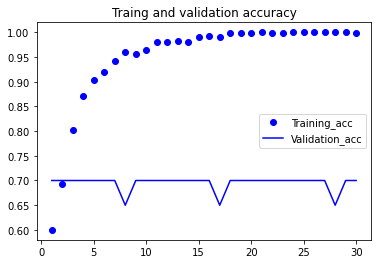

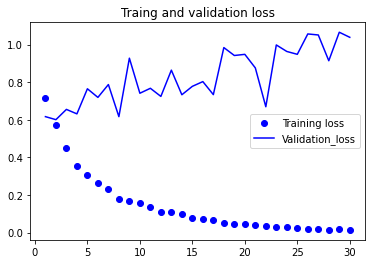

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training_acc')
plt.plot(epochs,val_acc,'b',label='Validation_acc')
plt.title('Traing and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation_loss')
plt.title('Traing and validation loss')
plt.legend()

plt.show()

[[1.9810078e-29]]


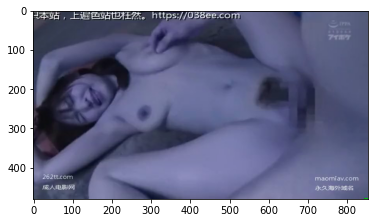

In [68]:
import cv2
img = cv2.imread(os.path.join(train_dir, 'fuckb\\00002415.jpg'), 1)
plt.imshow(img)
img = cv2.resize(img,(256, 256)).reshape((1, 256, 256, 3))
feature = conv_base.predict(img).reshape((1, 8 * 8 * 512))

pred = model.predict(feature)
print(pred)

[[2.0936138e-11]]


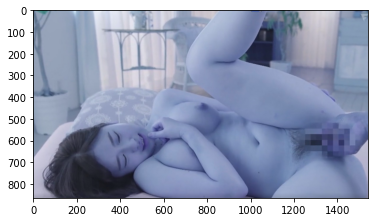

In [136]:
img = cv2.imread(os.path.join(test_dir,'fuckback\\0000000F.jpg'), 1)
plt.imshow(img)
img = cv2.resize(img,(256, 256)).reshape((1, 256, 256, 3))
feature = conv_base.predict(img).reshape((1, 8 * 8 * 512))

pred = model.predict(feature)
print(pred)

In [137]:
layer_outputs = [layer.output for layer in conv_base.layers[:8]]
activation_model = models.Model(conv_base.input, layer_outputs)

In [140]:
activations = activation_model.predict(img)
first_layer_activation = activations[2]
print(first_layer_activation.shape)

(1, 256, 256, 64)


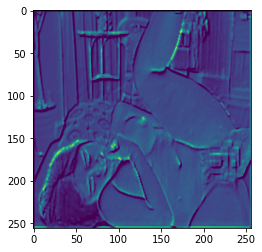

In [143]:
plt.imshow(first_layer_activation[0, :, :, 14], cmap='viridis')

In [144]:
model.save(r"G:\Work\pythonWanshenghua\TF\model\porn.h5")